In [1]:
import mne 
%matplotlib widget 
from os import chdir
from os.path import join
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd
import numpy as np

In [2]:
# Default Plotting Paramaters
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['lines.linewidth'] = 3
plt.ion()

In [3]:
MEG_path = '/work/MEG_data/workshop_data/0168/20250924_000000' ## you can pick your study group member
subjects_dir = '/work/freesurfer'
behaviour_path = '/work/MEG_data/workshop_data/behavioural_logs'

In [4]:
raw = mne.io.read_raw_fif(join(MEG_path, 'workshop_2025_raw.fif'), preload=True) 

Opening raw data file /work/MEG_data/workshop_data/0168/20250924_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 985000 ... 2581999 =    985.000 ...  2581.999 secs
Ready.
Opening raw data file /work/MEG_data/workshop_data/0168/20250924_000000/workshop_2025_raw-1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)

Using matplotlib as 2D backend.


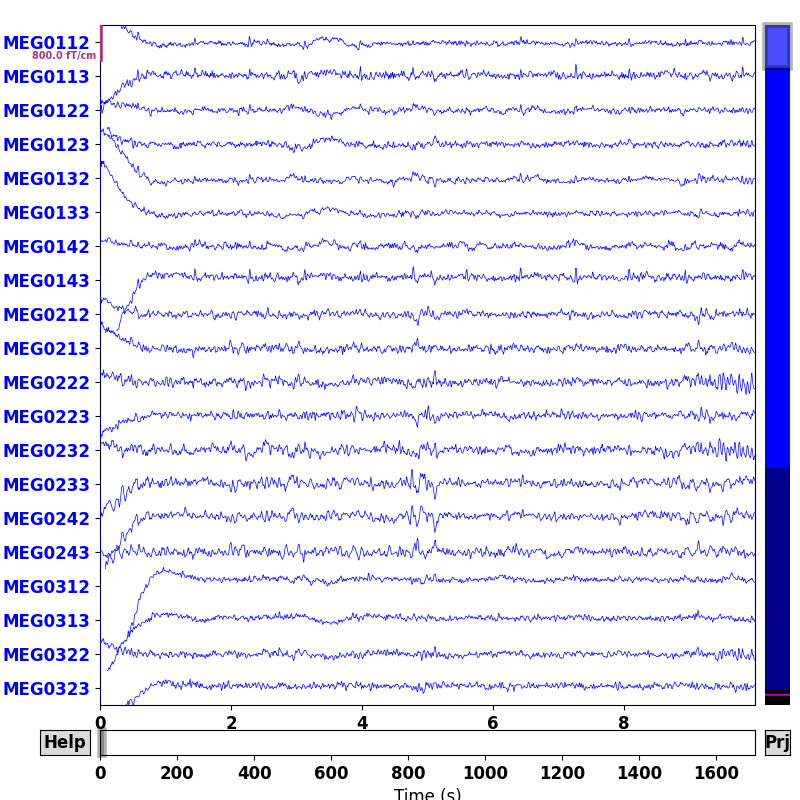

In [5]:
#copy_bandpass = raw.copy()
#copy_bandpass.filter(h_freq=40,   l_freq=1); ## bandpass fillter of 1-40 Hz

raw.filter(h_freq=40, l_freq=1); ## this method ".filter()" modifies in the object in place
fig = raw.plot() ## you will note this is completely saturated (all blue) do the PSD and find out why

In [13]:
## what does it look after choosing an appropriate filter?
#raw.compute_psd().plot()

In [6]:
#%% FIND EVENTS

events = mne.find_events(raw, min_duration=0.002)
events_filtered = events[(events[:, 2] == 1) | (events[:, 2] == 3)]
pas_events = events_filtered.copy()   # keeps shape (n_events, 3)
behaviour = pd.read_csv(join(behaviour_path, '0168_2025_09_24_135504_experiment_data.csv'), index_col=False)
pas_events[:, 2] = behaviour['subjective_response'] + 20

Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]


In [13]:
# Epochs
event_id = {'pas1': 21, 'pas2': 22, 'pas3': 23, 'pas4': 24}
epochs = mne.Epochs(raw, events=pas_events, event_id=event_id, tmin=-0.2, tmax=0.55, baseline=(None,0), reject = dict(eog=250e-6))

Not setting metadata
400 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated


In [14]:
## CREATING AVERAGES AND DIFFERENCE WAVES

### NEW CODE

evokeds = list()
for event in epochs.event_id:
    evokeds.append(epochs[event].average())

## this might help you along
evoked_diffs = list()
diffs = ['pas1', 'pas2', 'pas3','pas4']
for diff in diffs:
    evoked_diff = evokeds[0].copy() # create a copy
    evoked_diff.data -= evokeds[1].data # modify the data in place
    evoked_diff.comment = diff

    Rejecting  epoch based on EOG : ['EOG001']


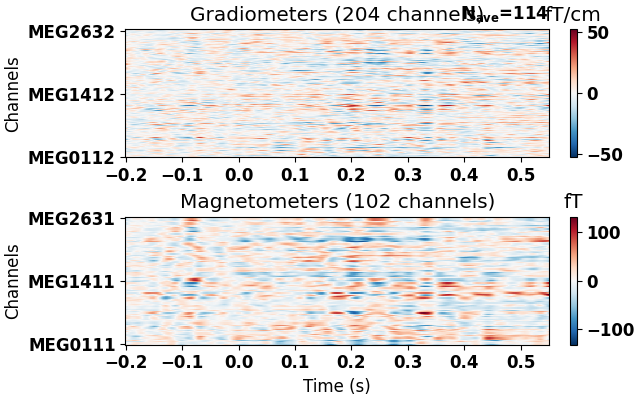

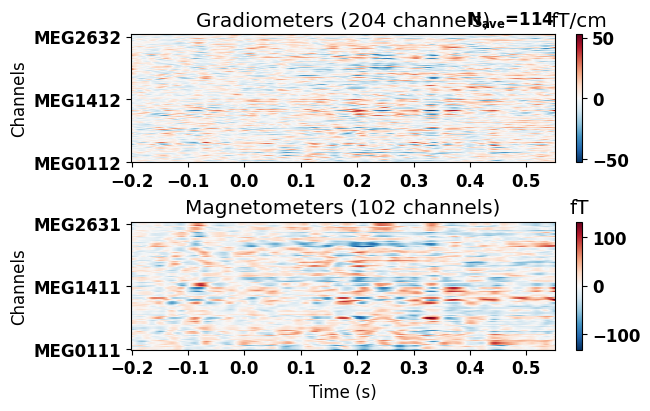

In [15]:
#mne.viz.plot_evoked(evoked_diff)
#mne.viz.plot_evoked_topo(evoked_diff)
#mne.viz.plot_evoked_topomap(evoked_diff)
#mne.viz.plot_evoked_joint(evoked_diff)
mne.viz.plot_evoked_image(evoked_diff)

In [16]:
## GET FORWARD MODEL

### NEW CODE

info = epochs.info
trans = join(MEG_path, 'workshop_2025-trans.fif') 
src = join(subjects_dir, '0168', 'bem', '0168' + '-oct-6-src.fif')
bem = join(subjects_dir, '0168', 'bem', '0168' + '-5120-bem-sol.fif')

fwd = mne.make_forward_solution(
                            info, trans,
                            src, bem)

Source space          : /work/freesurfer/0168/bem/0168-oct-6-src.fif
MRI -> head transform : /work/MEG_data/workshop_data/0168/20250924_000000/workshop_2025-trans.fif
Measurement data      : instance of Info
Conductor model   : /work/freesurfer/0168/bem/0168-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /work/freesurfer/0168/bem/0168-oct-6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.998628 -0.002263 0.052321      -2.02 mm
    -0.020717 0.900498 0.434366      12.21 mm
    -0.048098 -0.434854 0.899216      26.00 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.996579 0.036173 0.074306       0.91 mm
    -0.038395 0.998850 0.028686      -7.03 mm
    -0.073183 -0.031441 0.996822      54.85 mm
    0.000000 0.000000 0.000000       1.

Using data from preloaded Raw for 114 events and 751 original time points ...


0 bad epochs dropped
Using data from preloaded Raw for 137 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
1 bad epochs dropped
Using data from preloaded Raw for 75 events and 751 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 74 events and 751 original time points ...
0 bad epochs dropped
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 80199
[done]
Computing rank from covariance with rank=None
    Using tolerance 1e-14 (2.2e-16 eps * 102 dim * 0.45  max singular value)
    Estimated rank (mag): 96
    MAG: rank 96 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 4.6e-13 (2.2e-16 eps * 204 dim * 10  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 d

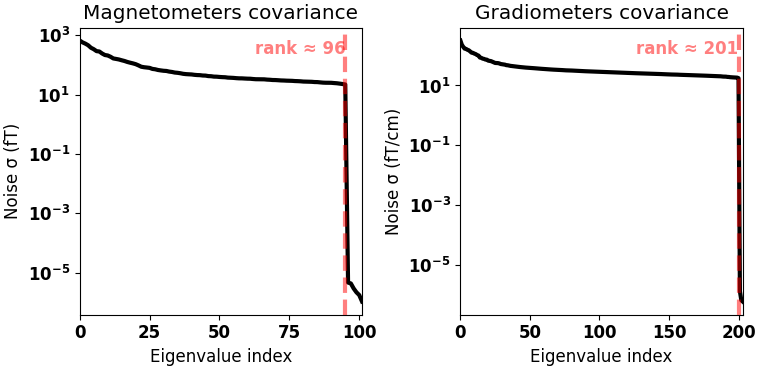

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

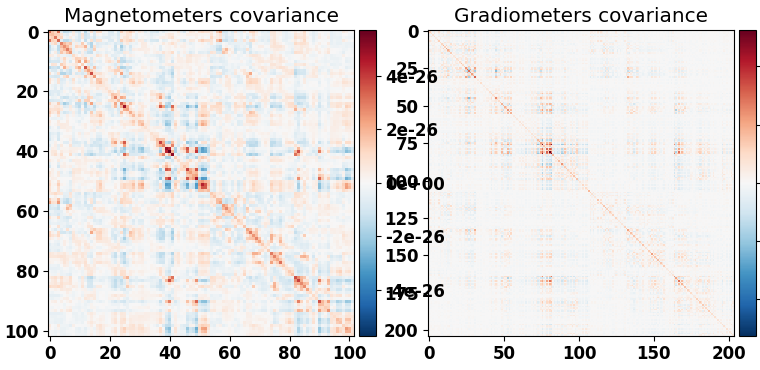

In [17]:
noise_cov = mne.compute_covariance(epochs, tmin=None, tmax=0)
noise_cov.plot(raw.info)

In [19]:
for i, ev in enumerate(evokeds):
    print(f"{i}: {ev.comment}")

0: pas1
1: pas2
2: pas3
3: pas4


In [23]:
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd,
                                                          noise_cov)

# estimating the source pattern for each time point Vvox(t)
# right auditory stimulus (evokeds_sample[1])
MNE = mne.minimum_norm.apply_inverse(evokeds[1], inverse_operator,
                                     method='dSPM')
## standard is to use method=dSPM for depth correction

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7759/8196 = 10.005992
    scale = 4.32678e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 7.1e-13 (2.2e-16 eps * 306 dim * 10  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and w

In [59]:
MNE

<SourceEstimate | 8196 vertices, subject : 0168, tmin : -200.0 (ms), tmax : 550.0 (ms), tstep : 1.0 (ms), data shape : (8196, 751), ~47.0 MiB>

In [42]:
#labels_path = '/work/freesurfer/0168/label'
#labels = (mne.read_labels_from_annot('0168', subjects_dir=subjects_dir))

labels = mne.read_labels_from_annot('0168', subjects_dir=subjects_dir)

# Filter for caudal middle frontal in both hemispheres
lh_cmf_label = [lab for lab in labels if 'caudalmiddlefrontal' in lab.name and lab.hemi == 'lh'][0]
rh_cmf_label = [lab for lab in labels if 'caudalmiddlefrontal' in lab.name and lab.hemi == 'rh'][0]
lh_ros_label = [lab for lab in labels if 'rostralmiddlefrontal' in lab.name and lab.hemi == 'lh'][0]
rh_ros_label = [lab for lab in labels if 'rostralmiddlefrontal' in lab.name and lab.hemi == 'rh'][0]

Reading labels from parcellation...
   read 34 labels from /work/freesurfer/0168/label/lh.aparc.annot
   read 34 labels from /work/freesurfer/0168/label/rh.aparc.annot


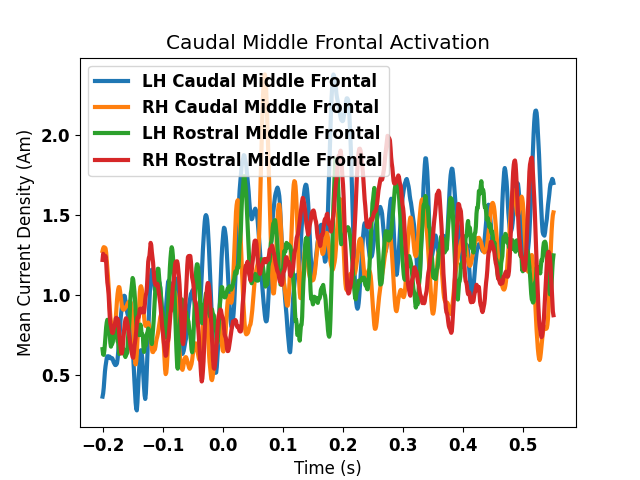

In [51]:
stc_lh_cmf = MNE.in_label(lh_cmf_label)
stc_rh_cmf = MNE.in_label(rh_cmf_label)
stc_lh_ros = MNE.in_label(lh_ros_label)
stc_rh_ros = MNE.in_label(rh_ros_label)
plt.figure()
plt.plot(stc_lh_cmf.times, stc_lh_cmf.data.mean(axis=0), label='LH Caudal Middle Frontal')
plt.plot(stc_rh_cmf.times, stc_rh_cmf.data.mean(axis=0), label='RH Caudal Middle Frontal')
plt.plot(stc_lh_ros.times, stc_lh_ros.data.mean(axis=0), label='LH Rostral Middle Frontal')
plt.plot(stc_rh_ros.times, stc_rh_ros.data.mean(axis=0), label='RH Rostral Middle Frontal')
plt.xlabel('Time (s)')
plt.ylabel('Mean Current Density (Am)')
plt.title('Caudal Middle Frontal Activation')
plt.legend()
plt.show()

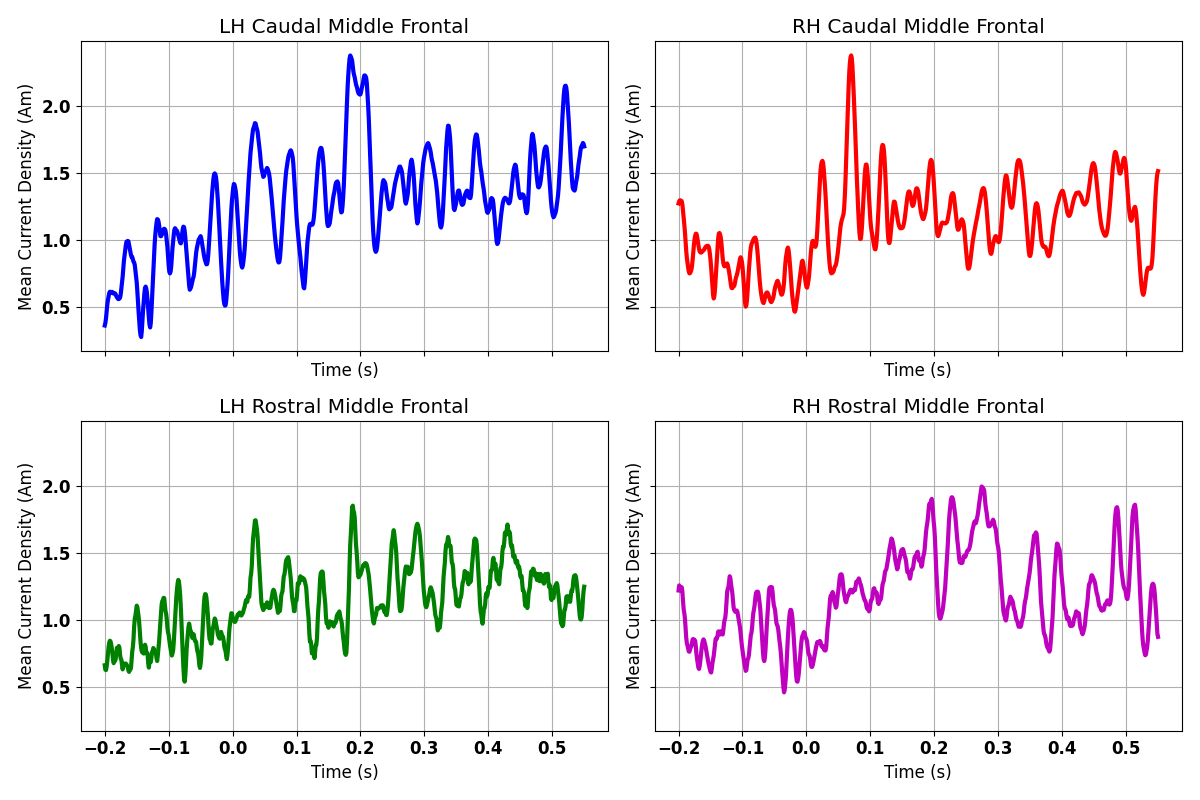

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# Plot LH Caudal Middle Frontal
axs[0, 0].plot(stc_lh_cmf.times, stc_lh_cmf.data.mean(axis=0), color='b')
axs[0, 0].set_title('LH Caudal Middle Frontal')

# Plot RH Caudal Middle Frontal
axs[0, 1].plot(stc_rh_cmf.times, stc_rh_cmf.data.mean(axis=0), color='r')
axs[0, 1].set_title('RH Caudal Middle Frontal')

# Plot LH Rostral Middle Frontal
axs[1, 0].plot(stc_lh_ros.times, stc_lh_ros.data.mean(axis=0), color='g')
axs[1, 0].set_title('LH Rostral Middle Frontal')

# Plot RH Rostral Middle Frontal
axs[1, 1].plot(stc_rh_ros.times, stc_rh_ros.data.mean(axis=0), color='m')
axs[1, 1].set_title('RH Rostral Middle Frontal')

# Shared labels
for ax in axs.flat:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean Current Density (Am)')
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Source Activation in Frontal Labels', fontsize=16, y=1.02)
plt.show()

In [52]:
import os
import mne
import pandas as pd
from os.path import join

#base_meg_path = '/work/MEG_data/workshop_data/0168/20250924_000000'
#subjects_dir = '/work/freesurfer'
#behaviour_path = '/work/MEG_data/workshop_data/behavioural_logs'

subject_info = {
    '0164': {'date': '20251003', 'timestamp': '101853'},
    '0165': {'date': '20250923', 'timestamp': '140007'},
    '0168': {'date': '20250924', 'timestamp': '135504'},
    '0169': {'date': '20250923', 'timestamp': '110138'},
    '0170': {'date': '20250924', 'timestamp': '121645'}
}


def preprocess_subjects(subject_info, base_meg_path, behaviour_path, subjects_dir, raw_fname='workshop_2025_raw.fif'):
    """
    subject_info: dict mapping subject ID to {'date': 'YYYYMMDD', 'timestamp': 'HHMMSS'}
    """
    inverse_solutions = dict()

    for subj, info in subject_info.items():
        date_str = info['date']
        timestamp = info['timestamp']
        print(f'Processing subject {subj} ({date_str} @ {timestamp})...')

        # Define paths
        subj_meg_path = join(base_meg_path, subj, f'{date_str}_000000')
        raw_fpath = join(subj_meg_path, raw_fname)
        trans = join(subj_meg_path, f'workshop_2025-trans.fif')
        src = join(subjects_dir, subj, 'bem', f'{subj}-oct-6-src.fif')
        bem = join(subjects_dir, subj, 'bem', f'{subj}-5120-bem-sol.fif')
        behav_file = join(behaviour_path, f'{subj}_{date_str[:4]}_{date_str[4:6]}_{date_str[6:]}_{timestamp}_experiment_data.csv')

        # Load and filter raw data
        raw = mne.io.read_raw_fif(raw_fpath, preload=True)
        raw.filter(l_freq=1, h_freq=40)

        # Find and filter events
        events = mne.find_events(raw, min_duration=0.002)
        events_filtered = events[(events[:, 2] == 1) | (events[:, 2] == 3)]
        pas_events = events_filtered.copy()

        # Load behavioral data and assign PAS labels
        behaviour = pd.read_csv(behav_file, index_col=False)
        pas_events[:, 2] = behaviour['subjective_response'] + 20

        # Epoching
        event_id = {'pas1': 21, 'pas2': 22, 'pas3': 23, 'pas4': 24}
        epochs = mne.Epochs(raw, events=pas_events, event_id=event_id,
                            tmin=-0.2, tmax=0.55, baseline=(None, 0),
                            reject=dict(eog=250e-6))

        # Average evoked responses
        evokeds = [epochs[event].average() for event in event_id]

        # Forward model
        fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src, bem=bem)

        # Noise covariance
        noise_cov = mne.compute_covariance(epochs, tmin=None, tmax=0)

        # Inverse operator
        inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)

        # Apply inverse to PAS2 (index 1)
        stc = mne.minimum_norm.apply_inverse(evokeds[1], inverse_operator, method='dSPM')

        inverse_solutions[subj] = stc

    return inverse_solutions



results = preprocess_subjects(subject_info,
                              base_meg_path='/work/MEG_data/workshop_data',
                              behaviour_path='/work/MEG_data/workshop_data/behavioural_logs',
                              subjects_dir='/work/freesurfer')





Processing subject 0164 (20251003 @ 101853)...
Opening raw data file /work/MEG_data/workshop_data/0164/20251003_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 2974000 ... 4471999 =   2974.000 ...  4471.999 secs
Ready.
Reading 0 ... 1497999  =      0.000 ...  1497.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

In [53]:
results

{'0164': <SourceEstimate | 8196 vertices, subject : 0164, tmin : -200.0 (ms), tmax : 550.0 (ms), tstep : 1.0 (ms), data shape : (8196, 751), ~47.0 MiB>,
 '0165': <SourceEstimate | 8196 vertices, subject : 0165, tmin : -200.0 (ms), tmax : 550.0 (ms), tstep : 1.0 (ms), data shape : (8196, 751), ~47.0 MiB>,
 '0168': <SourceEstimate | 8196 vertices, subject : 0168, tmin : -200.0 (ms), tmax : 550.0 (ms), tstep : 1.0 (ms), data shape : (8196, 751), ~47.0 MiB>,
 '0169': <SourceEstimate | 8196 vertices, subject : 0169, tmin : -200.0 (ms), tmax : 550.0 (ms), tstep : 1.0 (ms), data shape : (8196, 751), ~47.0 MiB>,
 '0170': <SourceEstimate | 8196 vertices, subject : 0170, tmin : -200.0 (ms), tmax : 550.0 (ms), tstep : 1.0 (ms), data shape : (8196, 751), ~47.0 MiB>}

In [54]:
import json

def save_inverse_solutions_json(inverse_solutions, output_path):
    serializable_dict = {}

    for subj, stc in inverse_solutions.items():
        serializable_dict[subj] = {
            'data': stc.data.tolist(),  # Convert NumPy array to list
            'times': stc.times.tolist(),
            'vertices': [v.tolist() for v in stc.vertices]
        }

    with open(output_path, 'w') as f:
        json.dump(serializable_dict, f, indent=2)

In [55]:
save_inverse_solutions_json(results, '/work/nbs/Neuro_Subjective_Experience/data/freesurfer/inverse_solutions.json')


In [56]:
def load_inverse_solutions_json(json_path, subject_info):
    """
    json_path: path to the saved JSON file
    subject_info: dict mapping subject ID to {'date': ..., 'timestamp': ...} for locating subjects_dir
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    stc_dict = {}

    for subj, stc_data in data.items():
        vertices = [np.array(v) for v in stc_data['vertices']]
        stc = mne.SourceEstimate(
            data=np.array(stc_data['data']),
            vertices=vertices,
            tmin=stc_data['times'][0],
            tstep=stc_data['times'][1] - stc_data['times'][0],  # assumes uniform spacing
            subject=subj
        )
        stc_dict[subj] = stc

    return stc_dict


In [57]:
stc_dict = load_inverse_solutions_json('/work/nbs/Neuro_Subjective_Experience/data/freesurfer/inverse_solutions.json', subject_info)


In [58]:
stc_dict

{'0164': <SourceEstimate | 8196 vertices, subject : 0164, tmin : -200.0 (ms), tmax : 550.0000000000007 (ms), tstep : 1.0000000000000009 (ms), data shape : (8196, 751), ~47.0 MiB>,
 '0165': <SourceEstimate | 8196 vertices, subject : 0165, tmin : -200.0 (ms), tmax : 550.0000000000007 (ms), tstep : 1.0000000000000009 (ms), data shape : (8196, 751), ~47.0 MiB>,
 '0168': <SourceEstimate | 8196 vertices, subject : 0168, tmin : -200.0 (ms), tmax : 550.0000000000007 (ms), tstep : 1.0000000000000009 (ms), data shape : (8196, 751), ~47.0 MiB>,
 '0169': <SourceEstimate | 8196 vertices, subject : 0169, tmin : -200.0 (ms), tmax : 550.0000000000007 (ms), tstep : 1.0000000000000009 (ms), data shape : (8196, 751), ~47.0 MiB>,
 '0170': <SourceEstimate | 8196 vertices, subject : 0170, tmin : -200.0 (ms), tmax : 550.0000000000007 (ms), tstep : 1.0000000000000009 (ms), data shape : (8196, 751), ~47.0 MiB>}